# See Whether Molecular Dynamics Works
We want to make sure that molecular dynamics with our new model still produces reasonable structures

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from fff.simulation import run_calculator
from fff.sampling.md import MolecularDynamics
from fff.learning.gc.ase import SchnetCalculator
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.psi4 import Psi4
from ase.db import connect
from tqdm import tqdm
import numpy as np
import warnings
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configure the DFT methods

In [2]:
dft_kwargs = dict(method='pbe0-d3', basis='aug-cc-pvdz')

## Get a starting structure
Just a random structure to start with

In [3]:
with connect('initial-database.db') as db:
    atoms = next(db.select('natoms>16', limit=1)).toatoms()
atoms

Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=False, calculator=SinglePointCalculator(...))

## Make the SchNet and Psi4 Calculators
We're going to compare their performance

In [4]:
%%time
psi4_calc = Psi4(**dft_kwargs, num_threads=12)
psi4_eng = psi4_calc.get_potential_energy(atoms)

  Threads set to 12 by Python driver.
  Threads set to 12 by Python driver.


/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/psi4/driver/procrouting/empirical_dispersion.py:212: FutureWarning: Using the `local_options` keyword argument is deprecated in favor of using `task_config`, in version 0.30.0 it will stop working.
  jobrec = qcng.compute(


CPU times: user 3min 6s, sys: 3.33 s, total: 3min 9s
Wall time: 18.2 s


In [5]:
with open('tuned/model', 'rb') as fp:
    model = torch.load(fp, map_location='cpu').get_model()
ml_calc = SchnetCalculator(model)
ml_eng = ml_calc.get_potential_energy(atoms)

In [6]:
print(f'Energy of starting geom - Psi4: {psi4_eng:.1f}, SchNet: {ml_eng:.1f} eV. Error: {(psi4_eng - ml_eng) * 1000:.1f} meV')

Energy of starting geom - Psi4: -18703.9, SchNet: -18703.9 eV. Error: 75.1 meV


Off by a few meV, which is pretty good

## Check whether MD with the SchNet Model produces reasonable structures
The energies don't have to be accurate, it just has to make reasonable structures

In [12]:
%%time
MaxwellBoltzmannDistribution(atoms, temperature_K=100)
_, traj = MolecularDynamics().run_sampling(atoms, 10000, ml_calc, timestep=0.1, log_interval=500)

CPU times: user 10min 50s, sys: 7.62 s, total: 10min 58s
Wall time: 54.9 s


Get the energies using Psi4

In [14]:
%%time
spk_energies = [a.get_potential_energy() for a in traj]

CPU times: user 2.19 ms, sys: 29 µs, total: 2.21 ms
Wall time: 2.09 ms


In [15]:
psi4_energies = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for a in tqdm(traj):
        try:
            psi4_eng = psi4_calc.get_potential_energy(a)
        except BaseException:
            psi4_eng = np.nan
        psi4_energies.append(psi4_eng)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [05:41<00:00, 17.96s/it]


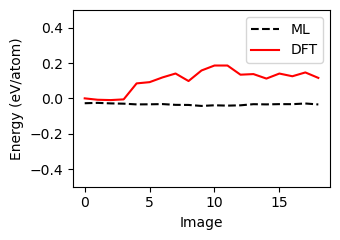

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot them normalized such that they start the same
ax.plot(np.subtract(spk_energies, psi4_energies[0]) / len(atoms), 'k--', label='ML')
ax.plot(np.subtract(psi4_energies, psi4_energies[0]) / len(atoms), 'r-', label='DFT')

ax.set_ylim(-0.5, 0.5)

ax.set_xlabel('Image')
ax.set_ylabel('Energy (eV/atom)')

ax.legend()
fig.tight_layout()

We start off with pretty similar energies, but they rapidly diverge. Molecular dynamics seemed to have found a spurious minimum! That'll be something we fix with active learning